In [154]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile

In [155]:
import time

# Dumped Harmonic Oscillator, compare model 
In this notebook we will compare the performance of the varius models on the dumped harmonic oscillator dataset. 

## Load data

In [156]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/DHOscillator_data.npy')
X = data[:,0]
Y = data[:,1:]

In [157]:
def data_loader(X, Y, batch_size):
    """
    Function to load data and divide it in batches
    input: X, Y, batch_size
    output: train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    """

    # divide in train, validation and test
    train_frac = 0.7
    val_frac = 0.15
    test_frac = 0.15

    train_val_X = X[:int((train_frac+val_frac)*len(X))]
    train_val_Y = Y[:int((train_frac+val_frac)*len(X)), :]
    train_X, val_X, train_Y, val_Y = train_test_split(
        train_val_X, 
        train_val_Y, 
        test_size=val_frac/(train_frac+val_frac), 
        random_state=42
        )

    test_X = X[int((train_frac+val_frac)*len(X)):]
    test_Y = Y[int((train_frac+val_frac)*len(X)):, :]

    # convert to torch tensor
    train_X = torch.tensor(train_X, dtype=torch.float32).view(-1, 1)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    val_X = torch.tensor(val_X, dtype=torch.float32).view(-1, 1)
    val_Y = torch.tensor(val_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32).view(-1, 1)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    # divide in batches train
    train_X_batches = torch.split(train_X, batch_size)
    train_Y_batches = torch.split(train_Y, batch_size)

    
    return train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y

In [158]:
# use the data loader to get the data, in this example we use only one batch
train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(X, Y, 595)

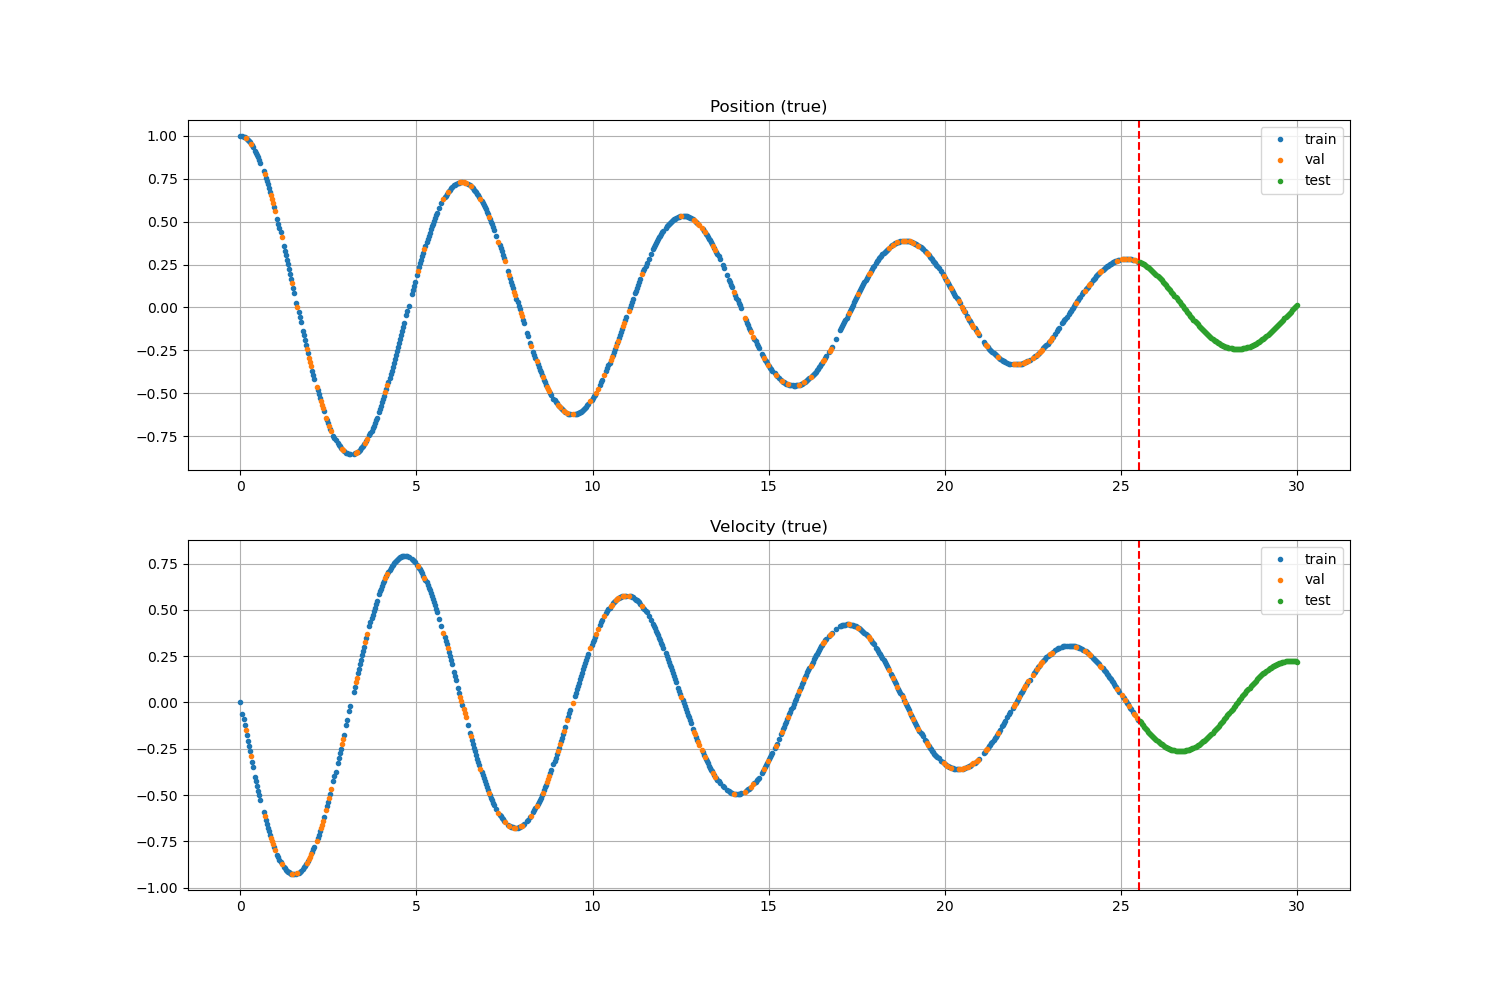

In [159]:
# plot the position 
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy(), '.', label='train')
plt.plot(val_X.detach().numpy(), val_Y[:, 0].detach().numpy(), '.', label='val')
plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy(), '.', label='test')
plt.grid()
plt.title('Position (true)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()

# plot the velocity
plt.subplot(2, 1, 2)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy(), '.', label='train')
plt.plot(val_X.detach().numpy(), val_Y[:, 1].detach().numpy(), '.', label='val')
plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy(), '.', label='test')
plt.grid()
plt.title('Velocity (true)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()


## Define some analysis functions

In [160]:
def plot_results(model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=False, name='model'):
    """
    Function to plot the results of the net for the
    position and velocity of the DHOscillator

    input: model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    output: plot of the results
    """

    # get predictions
    Y_pred_train = model(train_X_batches[0])
    Y_pred_val = model(val_X)
    Y_pred_test = model(test_X)

    # plot the position, and subplot the residue
    plt.figure(figsize=(18, 13))
    plt.subplot(2, 2, 1)

    marker='.'
    markersize=2

    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy(), marker, label='train true', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy(), marker, label='test true', markersize=markersize)
    plt.plot(train_X_batches[0].detach().numpy(), Y_pred_train[:, 0].detach().numpy(), marker, label='train pred', markersize=markersize)
    plt.plot(test_X.detach().numpy(), Y_pred_test[:, 0].detach().numpy(), marker, label='test pred', markersize=markersize)
    plt.grid()

    plt.title('Position (true and %s prediction)' % name)
    plt.axvline(x=30*0.85, color='r', linestyle='--')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy()-Y_pred_train[:, 0].detach().numpy(), marker, label='train', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy()-Y_pred_test[:, 0].detach().numpy(), marker, label='test', markersize=markersize)
    plt.grid()
    plt.ylabel('residue (true - pred)')
    plt.xlabel('time')
    plt.legend()
    plt.axvline(x=30*0.85, color='r', linestyle='--')


    # new figure for the velocity
    plt.subplot(2, 2, 2)

    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy(), marker, label='train true', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy(), marker, label='test true', markersize=markersize)
    plt.plot(train_X_batches[0].detach().numpy(), Y_pred_train[:, 1].detach().numpy(), marker, label='train pred', markersize=markersize)
    plt.plot(test_X.detach().numpy(), Y_pred_test[:, 1].detach().numpy(), marker, label='test pred', markersize=markersize)
    plt.grid()

    plt.title('Velocity (true and %s prediction)' % name)
    plt.axvline(x=30*0.85, color='r', linestyle='--')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy()-Y_pred_train[:, 1].detach().numpy(), marker, label='train', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy()-Y_pred_test[:, 1].detach().numpy(), marker, label='test', markersize=markersize)
    plt.grid()
    plt.ylabel('residue (true - pred)')
    plt.xlabel('time')
    plt.legend()
    plt.axvline(x=30*0.85, color='r', linestyle='--')
    
    if save:
        # save the figure
        plt.savefig('../plot/DHOscillator_%s_results.png' % name)

In [193]:
def get_losses(model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y):
    """
    Function to get the losses of the model for the train, validation and test set
    input: model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    output: train_loss, val_loss, test_loss
    """

    # get predictions
    Y_pred_train = model(train_X_batches[0])
    Y_pred_val = model(val_X)
    Y_pred_test = model(test_X)

    # get losses, to numpy
    train_loss = torch.mean((Y_pred_train - train_Y_batches[0])**2)
    val_loss = torch.mean((Y_pred_val - val_Y)**2)
    test_loss = torch.mean((Y_pred_test - test_Y)**2)

    # print losses
    print('Train loss:', train_loss.item())
    print('Validation loss:', val_loss.item())
    print('Test loss:', test_loss.item())

    return train_loss.item(), val_loss.item(), test_loss.item() 

In [194]:
# def a function that get the time for one prediction sampling 10 time the test set, not with cuda
def get_pred_time(model, test_X, n_samples=1000):
    """
    Function to get the time for one prediction
    input: model, test_X, n_samples
    output: time
    """

    # get the time for one prediction
    times = []
    for i in range(n_samples):
        start = time.time()
        Y_pred_test = model(test_X)
        end = time.time()
        times.append((end - start)/len(test_X))

    time_pred = np.mean(times)
    time_pred_std = np.std(times)

    print('Time for one prediction:', time_pred, '+/-', time_pred_std)

    return time_pred, time_pred_std
    

In [195]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 2))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

## Baseline model
Baseline model FFNN and PINN have the same architecture and where trained for the same amount of time and data.

In [196]:
# load the models
FFNN_baseline = torch.load('../models/DHO_FFNN_baseline.pt')
PINN_baseline = torch.load('../models/DHO_PINN_baseline.pt')

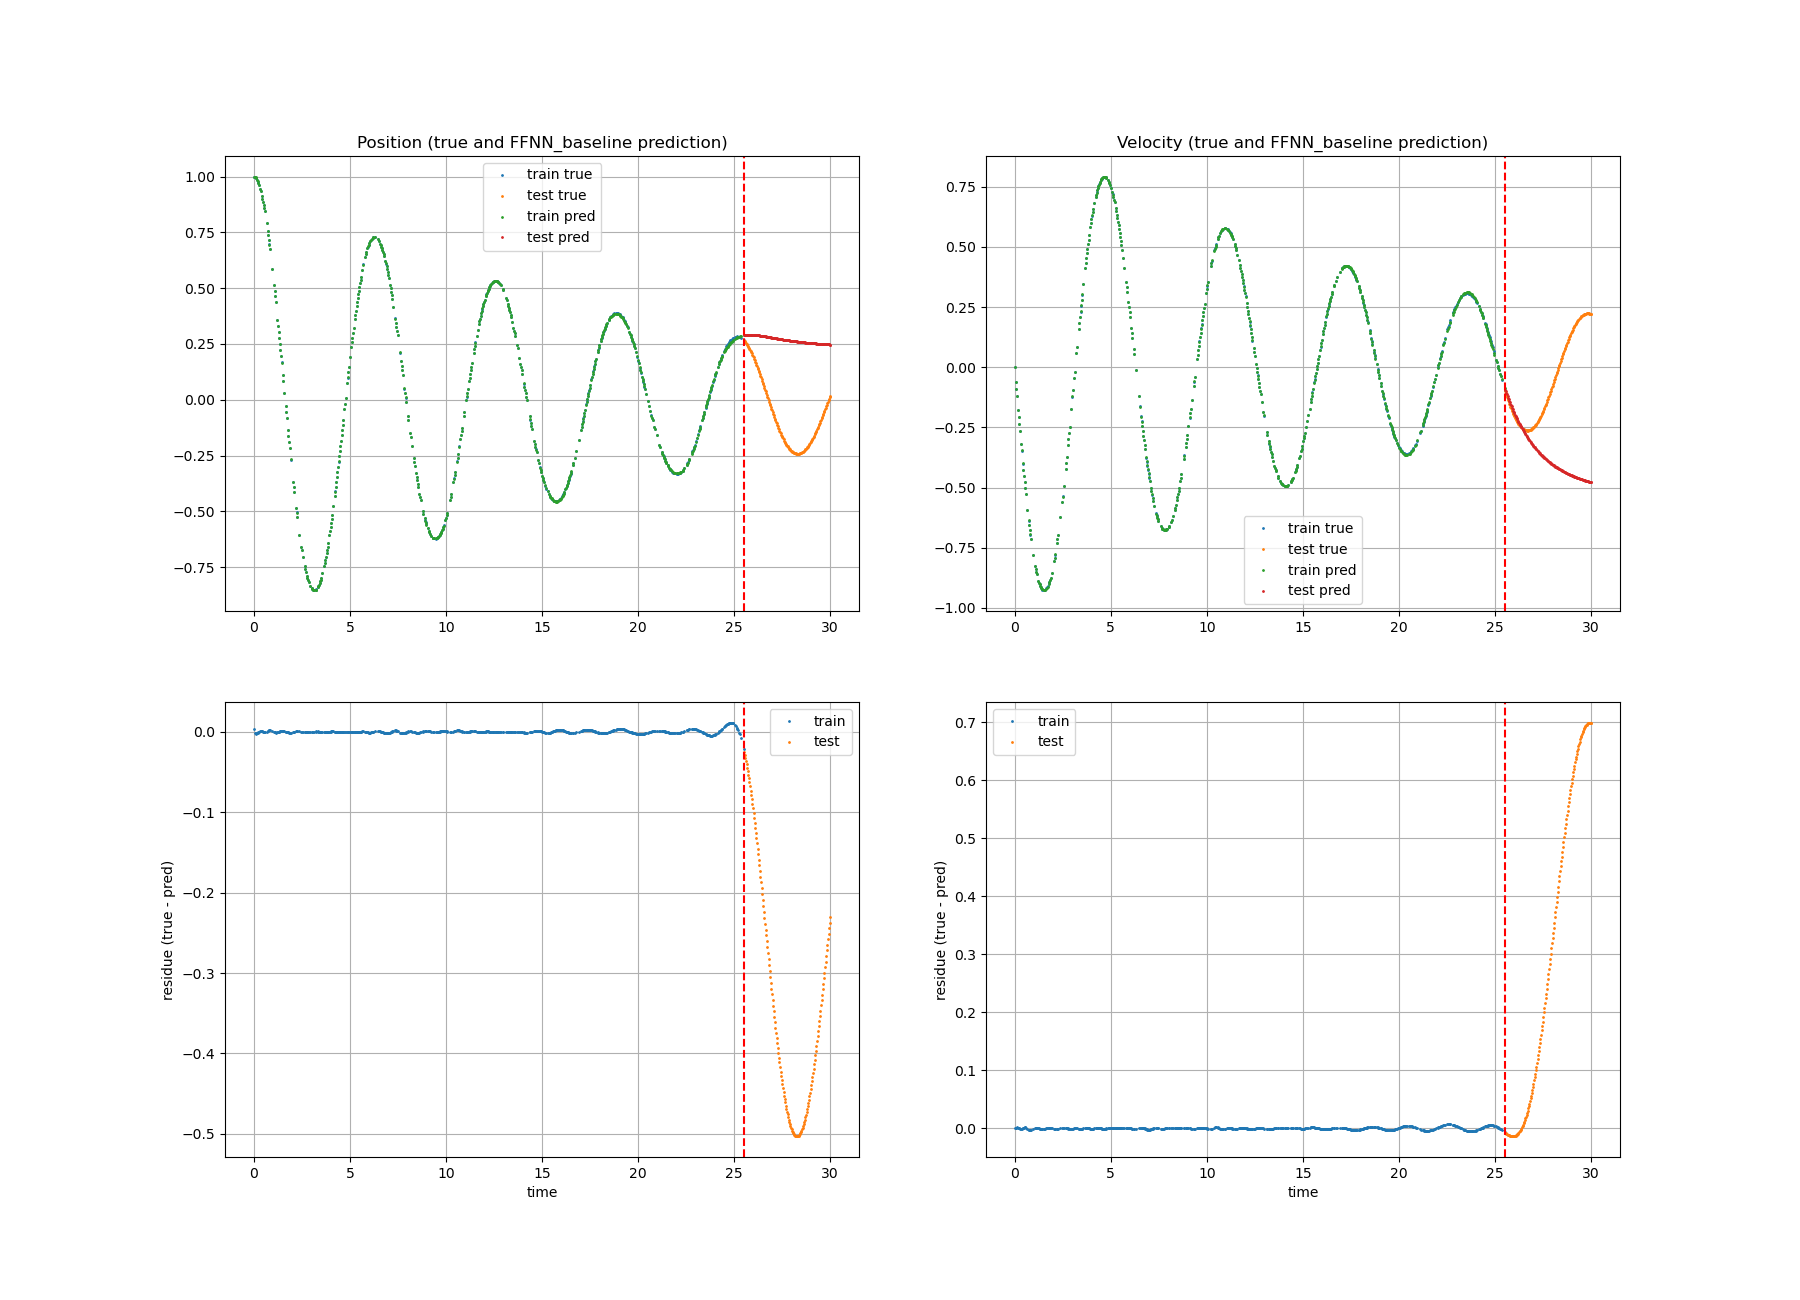

In [197]:
# plot results
plot_results(FFNN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=False, name='FFNN_baseline')

In [198]:
# get losses
FFNN_baseline_train_loss, FFNN_baseline_val_loss, FFNN_baseline_test_loss = get_losses(FFNN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y)

Train loss: 5.001572390028741e-06
Validation loss: 6.745639893779298e-06
Test loss: 0.1473110467195511


In [199]:
# get time
FFNN_baseline_time, FFNN_baseline_time_std = get_pred_time(FFNN_baseline, test_X, n_samples=100)

Time for one prediction: 4.0659268697102865e-06 +/- 6.174263771521612e-06


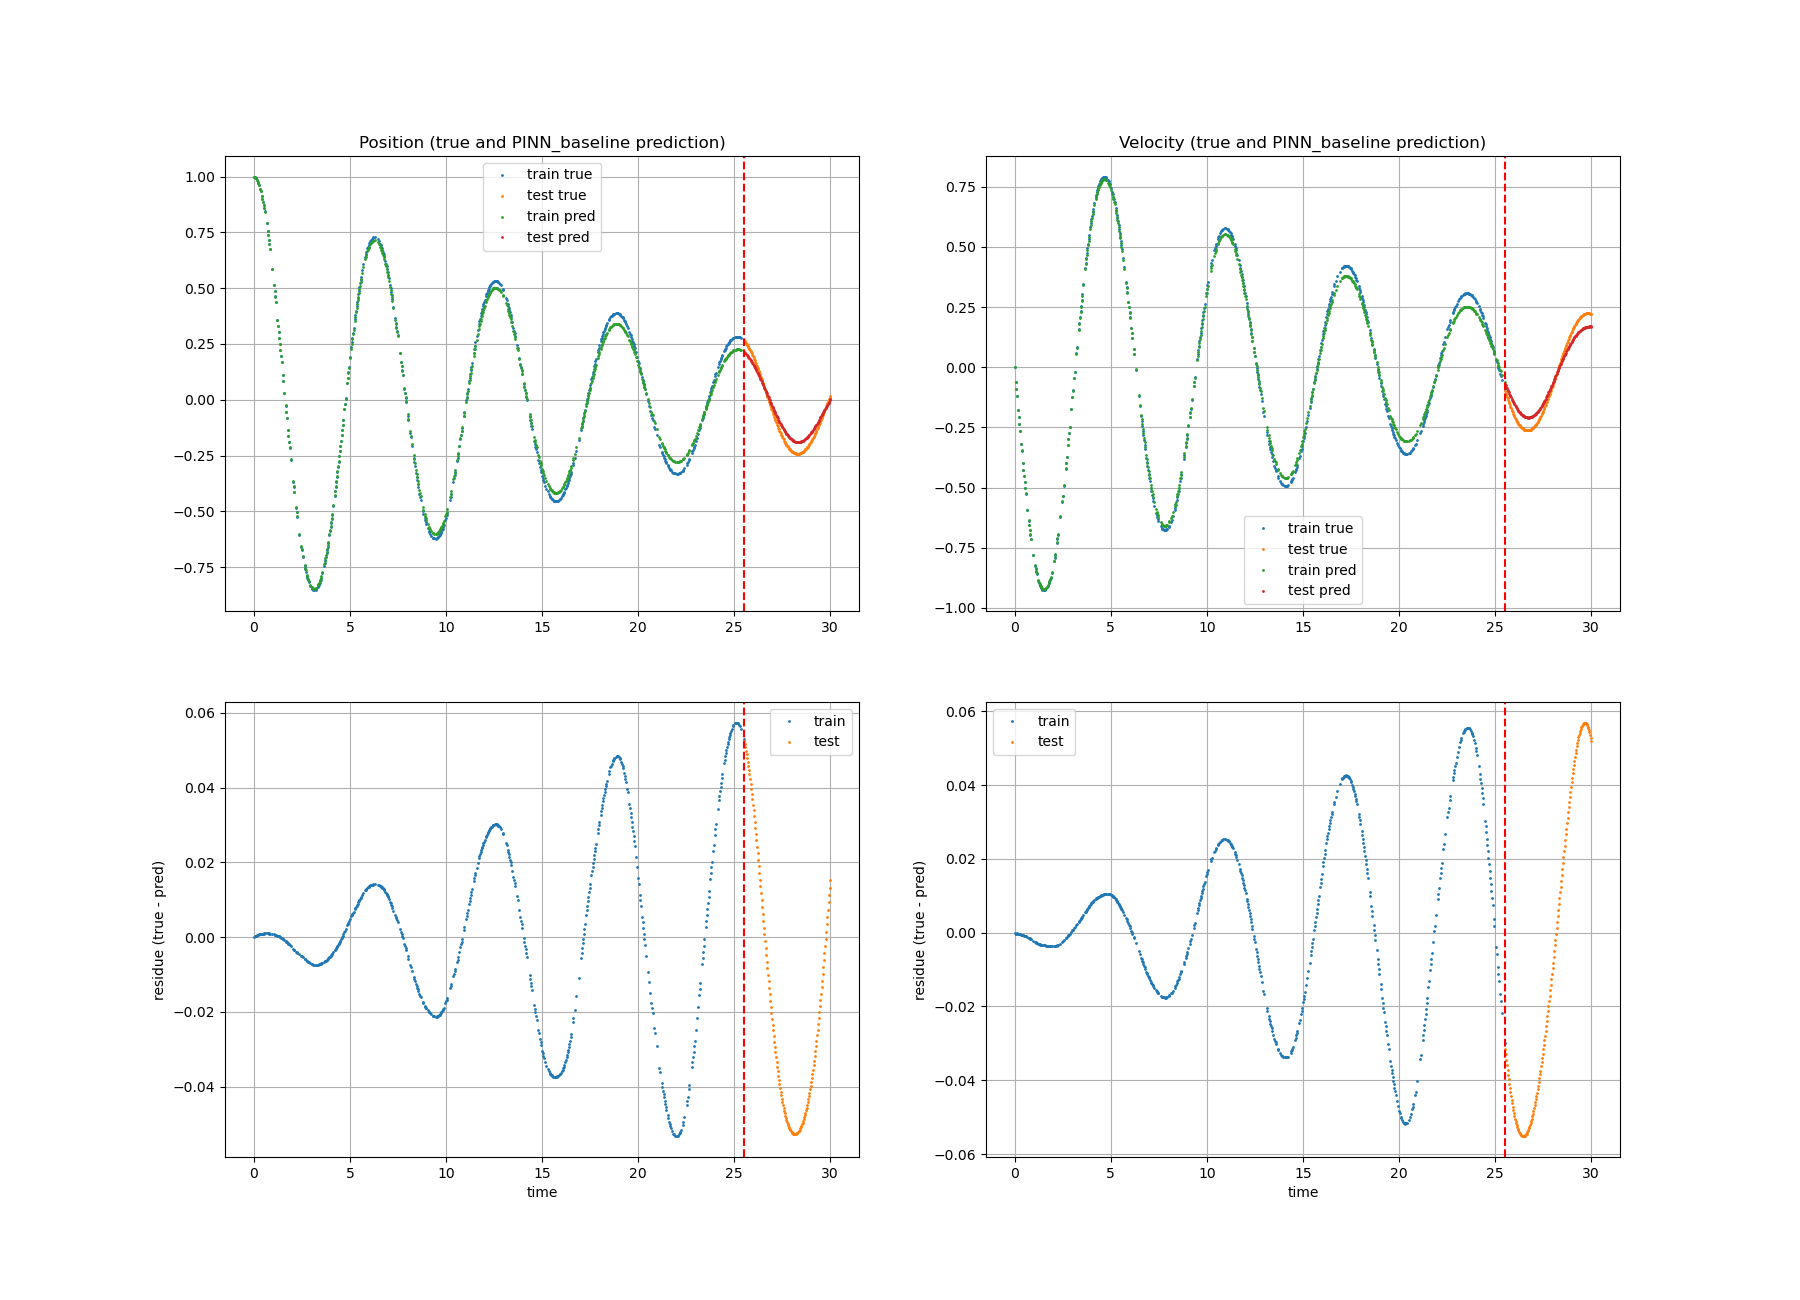

In [200]:
# plot results PINN
plot_results(PINN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=False, name='PINN_baseline')

In [201]:
# get losses
PINN_baseline_train_loss, PINN_baseline_val_loss, PINN_baseline_test_loss = get_losses(PINN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y)

Train loss: 0.0006238690693862736
Validation loss: 0.0006585018127225339
Test loss: 0.0015676728216931224


In [202]:
# get time
PINN_baseline_time, PINN_baseline_time_std = get_pred_time(PINN_baseline, test_X, n_samples=100)

Time for one prediction: 9.089851379394533e-06 +/- 2.864341080796645e-06


## RK4 model

In [95]:
def dumped_spring(t, Y):
    """
    This function calculates the derivative of the state vector Y at time t
    for a spring-mass-damper system.
    t (float): time
    Y (ndarray): state vector [position, velocity]

    Returns:
    dXdt (list): derivative of state vector
    """

    # define system parameters
    m = 1.0
    k = 1.0
    c = 0.1

    # return in np
    return np.array([Y[1], -k/m*Y[0] - c/m*Y[1]])

In [115]:
# get the first test point as starting point
Y0 = [1,0]
# get the timespan of the test
t = test_X.detach().numpy()
t_span = np.array([0, 100])
# show
print('Initial condition:', Y0)
print('Time span:', t_span)

Initial condition: [1, 0]
Time span: [  0 100]


In [124]:
# import @jit from numba
from numba import jit, njit
from math import sqrt
import time

In [125]:
# def a function that solve with regular RK4 method the ODE with a fixed time step dt
def RK4(dumped_spring, Y0, t_span, dt):
    """
    Function to solve the ODE with RK4 method
    input: dumped_spring, Y0, t_span, dt
    output: Y
    """

    # define the time
    t = np.arange(t_span[0], t_span[1], dt)
    # rewrtire the last line extracting the values
    # define the state vector
    Y = np.zeros((len(t), len(Y0)))
    Y[0] = Y0
    # loop over the time
    for i in range(len(t)-1):
        # get the derivative
        dYdt = dumped_spring(t[i], Y[i])
        # get the next state vector
        k1 = dt*np.array(dYdt)
        k2 = dt*np.array(dumped_spring(t[i]+dt/2, Y[i]+k1/2))
        k3 = dt*np.array(dumped_spring(t[i]+dt/2, Y[i]+k2/2))
        k4 = dt*np.array(dumped_spring(t[i]+dt, Y[i]+k3))
        Y[i+1] = Y[i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)

    # stack t and Y
    Y = np.hstack((t.reshape(-1, 1), Y))

    return Y


In [126]:
# def the analytical solution
def analytical_solution(t, Y0):
    """
    Function to get the analytical solution of the DHOscillator
    input: t, Y0
    output: Y
    """

    # define system parameters
    m = 1.0
    k = 1.0
    c = 0.1

    Omega = sqrt(k/m - (c/(2*m))**2)
    gamma = c/(2*m)
    A = 1

    return A*np.exp(-gamma*t)*np.cos(Omega*t)

In [127]:
# RK_dt = np.array([0.01, 0.001, 0.0001, epsilon])
RK_dt = np.array([1e-5, 1e-3, 1e-1, 1])

In [128]:
# for each dt solve the ODE, get the time of execution and the error
sol_RK = []
execution_time = []
for dt in RK_dt:
    start = time.time()
    sol_RK.append(RK4(dumped_spring, Y0, t_span, dt))
    end = time.time()
    execution_time.append(end - start)

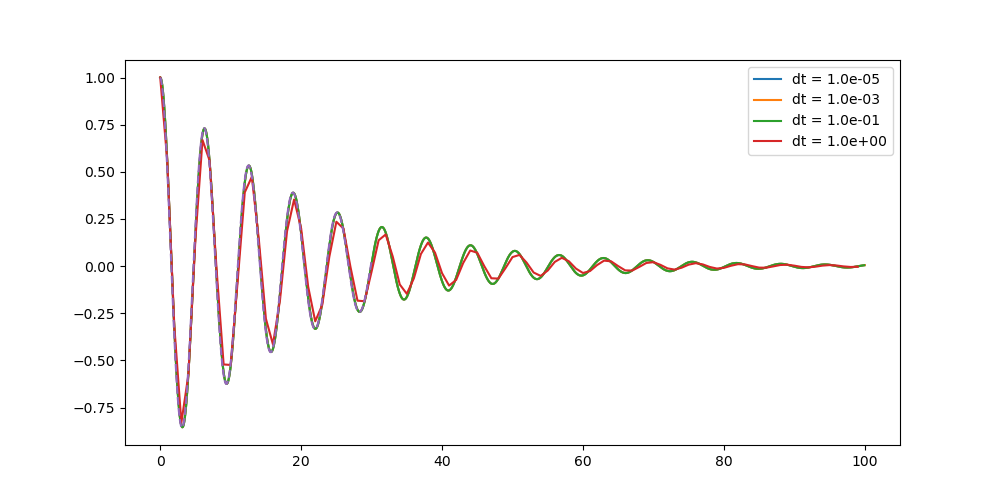

In [129]:
# plot the sol
plt.figure(figsize=(10, 5))
for i, sol in enumerate(sol_RK):
    plt.plot(sol[:, 0], sol[:, 1], label='dt = %.1e' % RK_dt[i])

plt.legend()

# plot the analytical solution
times = np.linspace(0, 30, 1000)
Y_analytical = analytical_solution(times, Y0)
plt.plot(times, Y_analytical, label='analytical', linestyle='--')

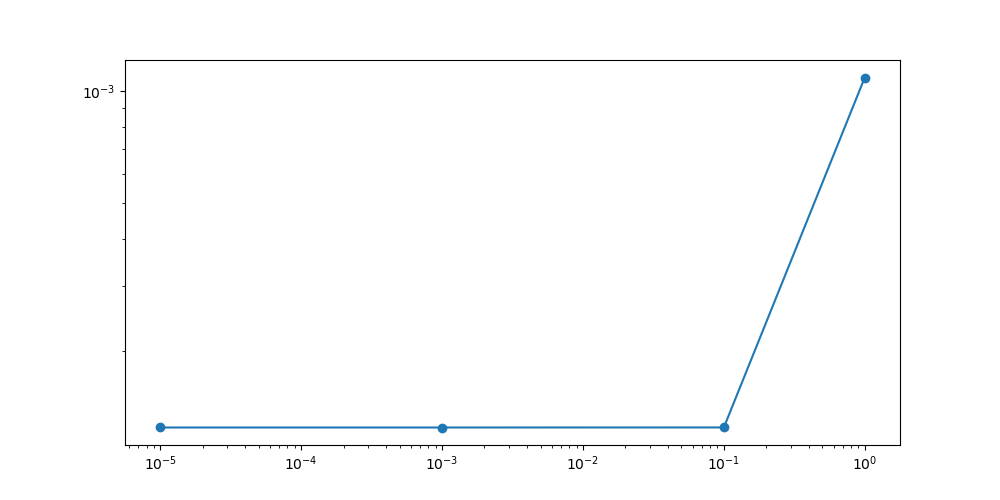

In [130]:
# get MSE between analytical and RK4 for each dt
MSE_RK = []
for sol in sol_RK:
    MSE_RK.append(np.mean((sol[:, 1] - analytical_solution(sol[:, 0], Y0))**2))

# plot the MSE
plt.figure(figsize=(10, 5))
plt.plot(RK_dt, MSE_RK, marker='o')
plt.xscale('log')
plt.yscale('log')

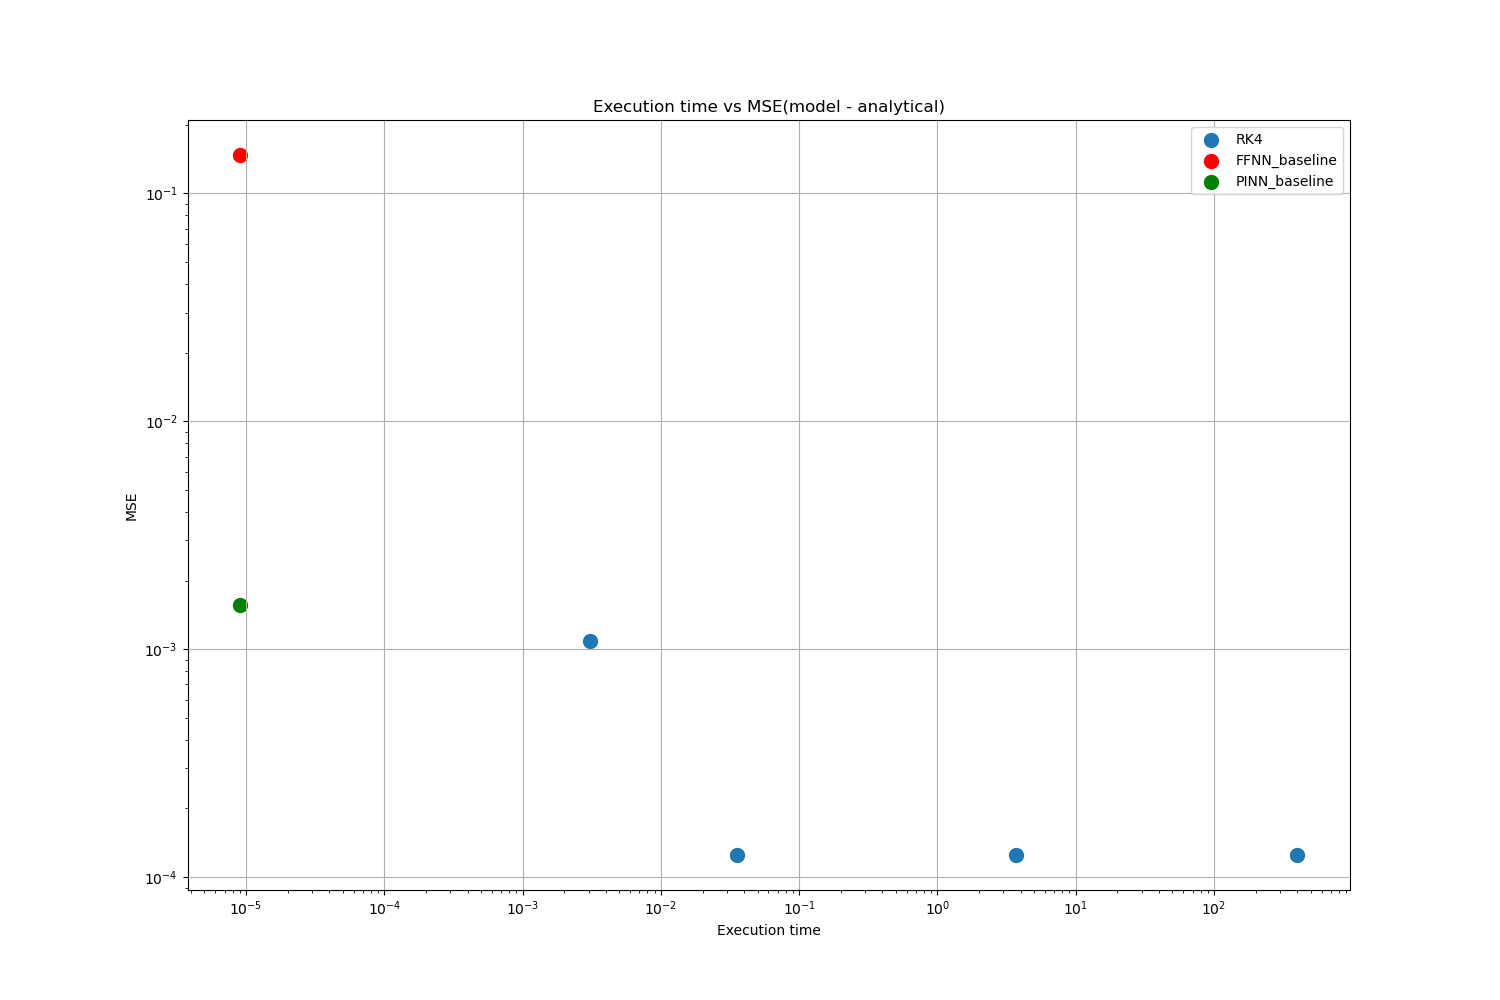

In [221]:
# scatter plot of the execution time and the MSE
plt.figure(figsize=(15, 10))
# marker size 10
plt.scatter(execution_time, MSE_RK, label='RK4', marker='o', s=100)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MSE')
plt.xlabel('Execution time')

# add the FFNN point
plt.scatter(PINN_baseline_time, FFNN_baseline_test_loss, label='FFNN_baseline', color='r', s=100)
plt.scatter(PINN_baseline_time, PINN_baseline_test_loss, label='PINN_baseline', color='g', s=100)
plt.legend()
plt.grid()

# title 
plt.title('Execution time vs MSE(model - analytical)')
# save the figure
plt.savefig('../plot/DHOscillator_execution_time_vs_MSE.png')

In [174]:
FFNN_baseline_test_loss

tensor(0.1473, grad_fn=<MeanBackward0>)